# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import plotly
import plotly.express as px

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('Data/bank_fin.zip', sep = ';')
df.head()

age         job  marital  education default       balance housing loan  \
0   59      admin.  married  secondary      no   2 343,00 $      yes   no   
1   56      admin.  married  secondary      no      45,00 $       no   no   
2   41  technician  married  secondary      no   1 270,00 $      yes   no   
3   55    services  married  secondary      no   2 476,00 $      yes   no   
4   54      admin.  married   tertiary      no     184,00 $       no   no   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may      1042         1     -1         0  unknown     yes  
1  unknown    5   may      1467         1     -1         0  unknown     yes  
2  unknown    5   may      1389         1     -1         0  unknown     yes  
3  unknown    5   may       579         1     -1         0  unknown     yes  
4  unknown    5   may       673         2     -1         0  unknown     yes

### Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

### Данные, связанные с последним контактом:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

### Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей маркетинговой кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей маркетинговой кампании)
- poutcome (результат прошлой маркетинговой кампании).

### Целевой признак:

Наша целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. 

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Данные имеют 11162 строк и 16 признаков, в balance имеется 25 пропусков.

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
unique_values = df['job'].value_counts(dropna=False)
print(unique_values)

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64


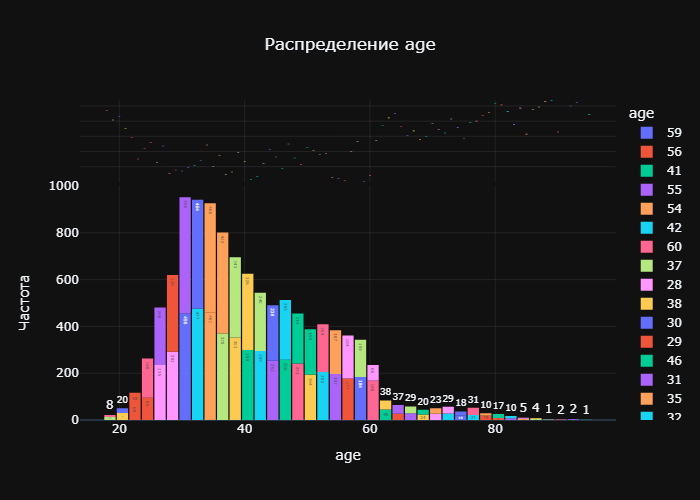

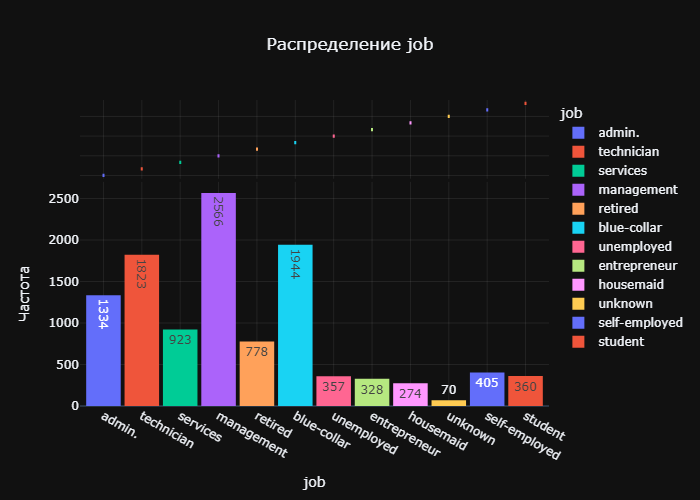

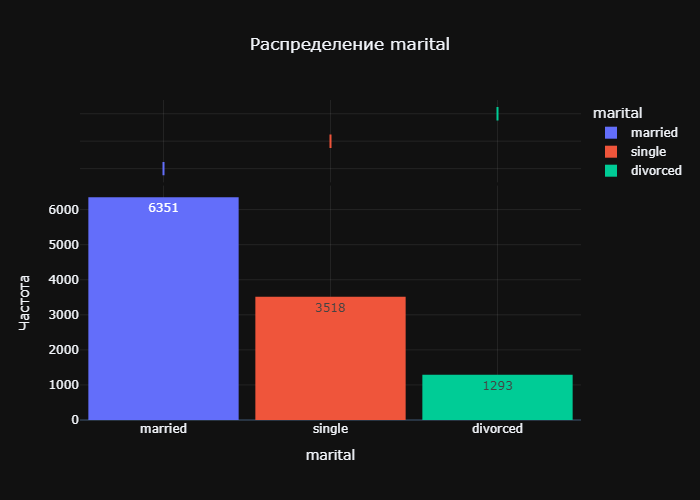

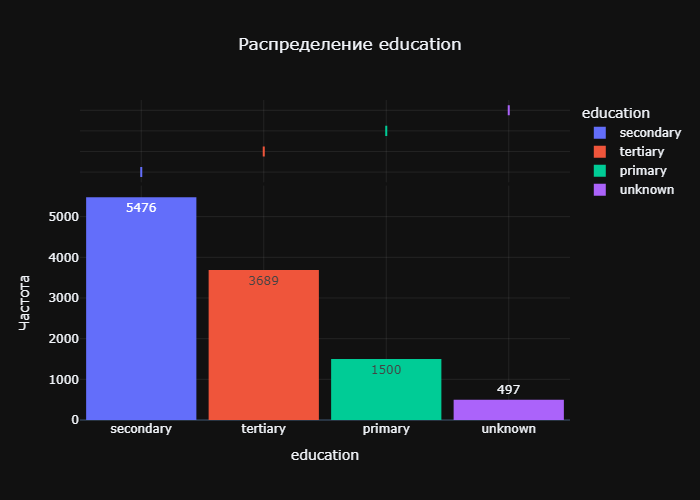

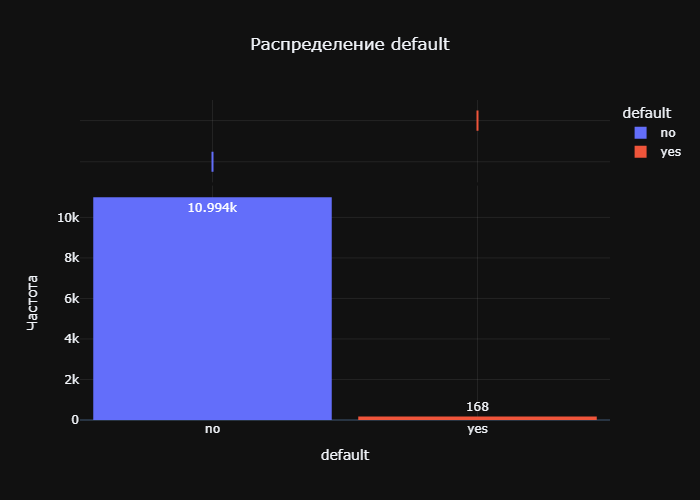

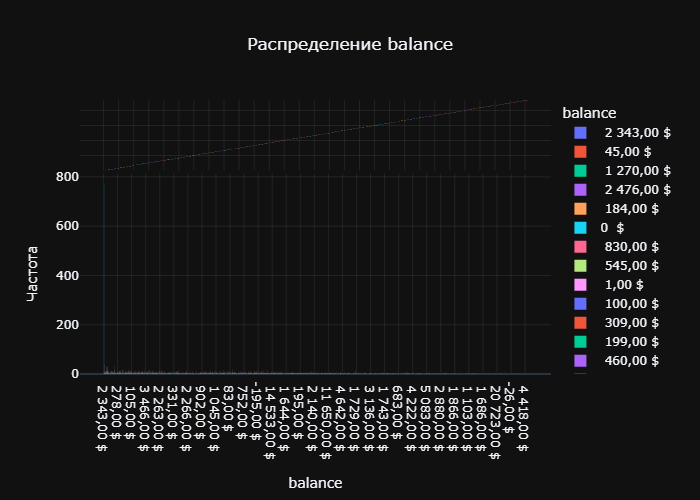

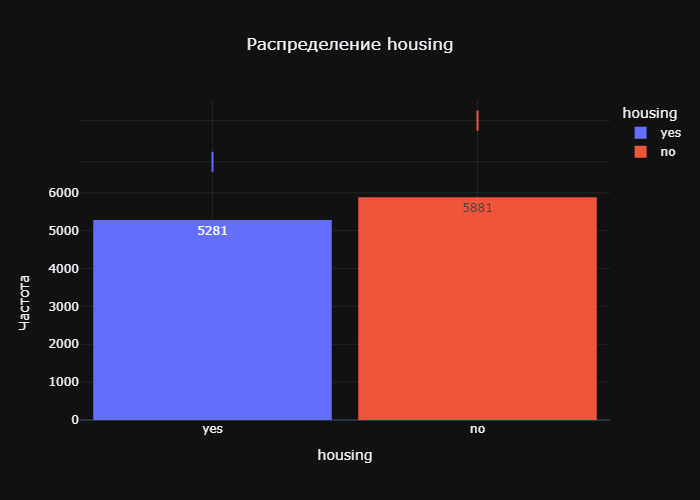

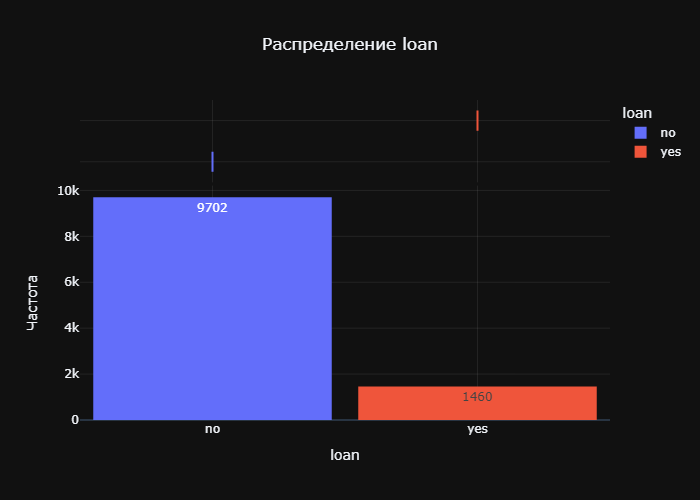

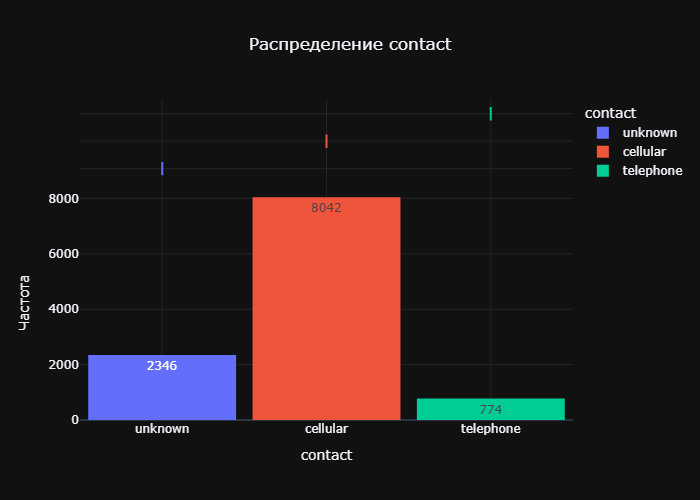

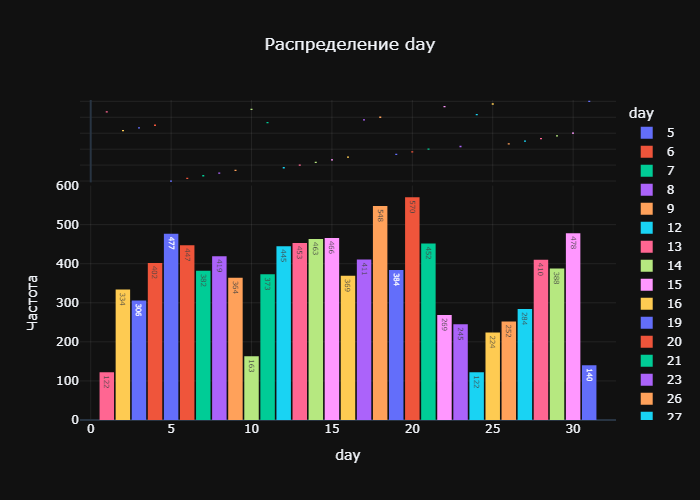

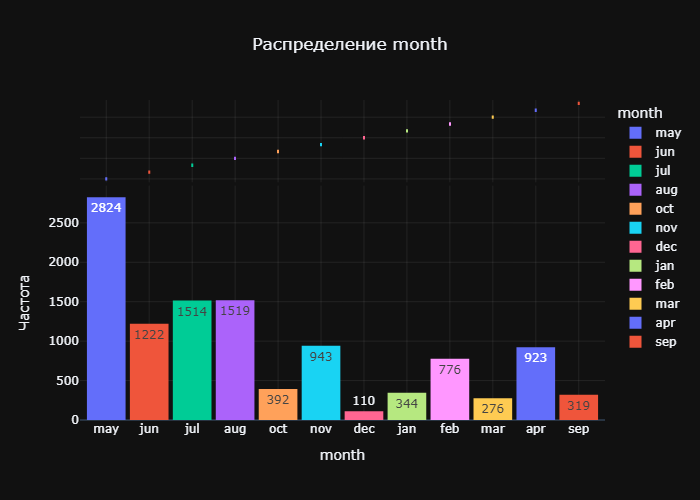

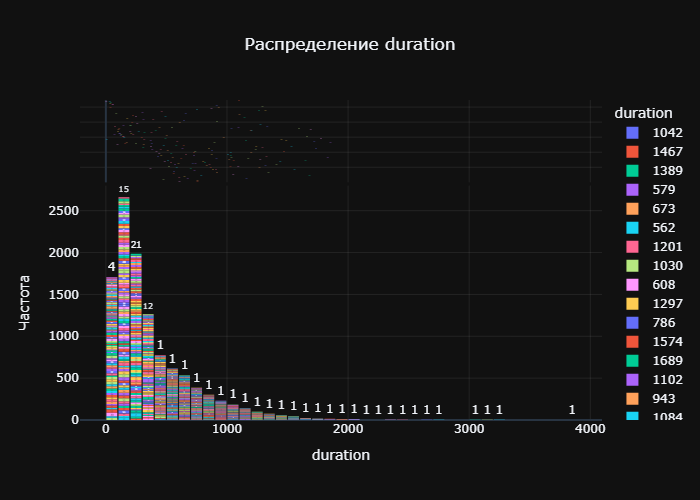

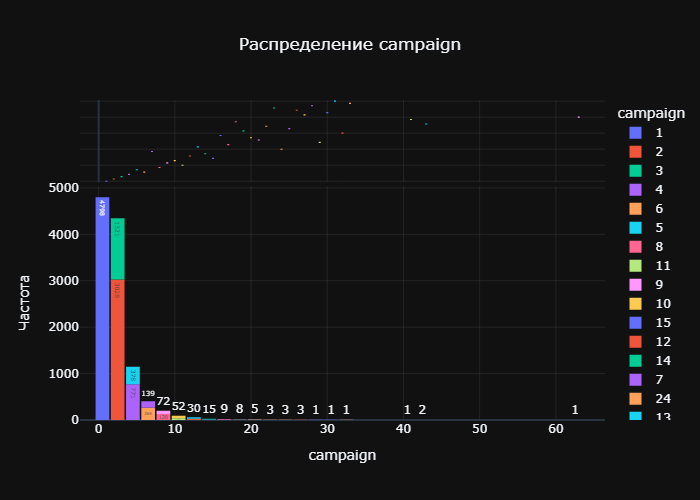

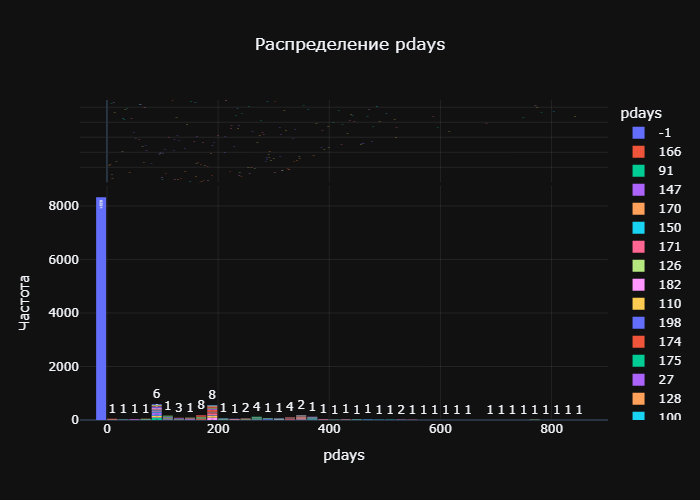

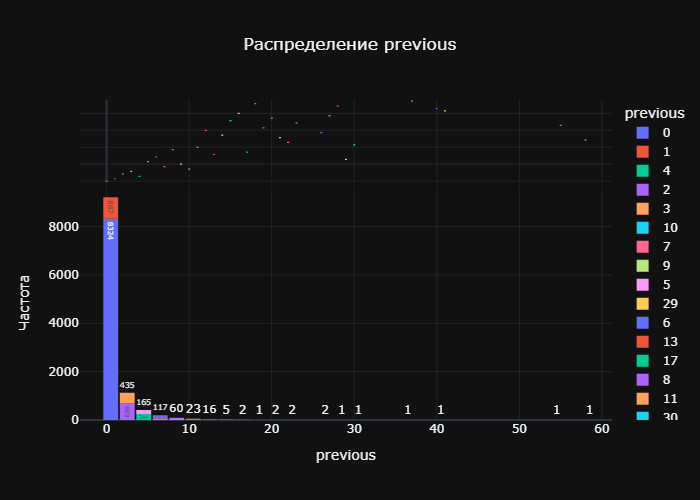

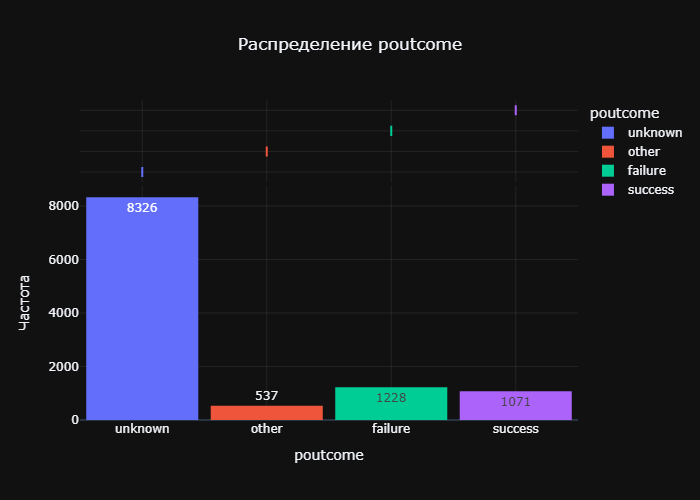

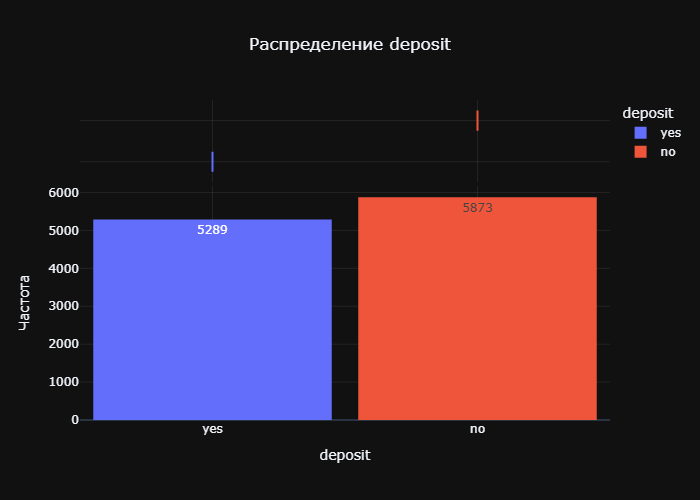

In [5]:
# Визуализируем распределение признаков в наборе данных
for i in list(df.columns):
    fig = px.histogram(
        df, 
        x=i, 
        title=f'Распределение {i}',  # Более информативное название
        marginal="box",  # Добавляем диаграмму размаха для оценки выбросов
        text_auto=True,  # Автоматическое отображение значений на столбцах
        color=i,  # Цветовая кодировка по значению признака
        nbins=50  # Увеличение количества столбцов для более детального распределения
    )

    # Настройка осей
    fig.update_layout(
        xaxis_title=f'{i}',
        yaxis_title='Частота',
        bargap=0.1,  # Расстояние между столбцами
        title_x=0.5,  # Заголовок по центру
        template='plotly_dark'  # Тема оформления графика (можно поменять)
    )

    # Добавление сетки и линий для большего контраста
    fig.update_xaxes(showgrid=True, gridwidth=0.1, gridcolor='LightGray')
    fig.update_yaxes(showgrid=True, gridwidth=0.1, gridcolor='LightGray')
    
    fig.show('png')

#### **Клиенты банка**:

- в возрасте(age) от 18 до 95 лет, многочисленная часть от 30 до 40 лет;
- большинство занято в сфере(job) в сфере management, blue-collar, technical, малочисленно - housemaid;
- почти 60% семейные люди(married), 11% - разведённые(divorced);
- с уровенем образования(education) secondary - 50%, c tertiary - 35%, primary - 15%;
- практически никто не имеет просроченной задолженности(default);
- одинаковое число клиентов, которые имеют/не имеют кредит на жильё(housing);
- кредит на личные нужды (loan) имеют всего 10%.

#### **Статистика банка**:

- самый активный месяц по контактам с клиентами(month) был май, в разрезе месяца(day) наименьшее число контактов было в 1, 10, 24 и 31 числах месяца;
- в основном продолжительность контактов(duration) от 40 до 300 сек. вопросы клиентов банка;
- результаты прошлой маркетинговой кампании(poutcome) из них 80%(unknown), 1%(other), 10%(failure) и 10%(success).


### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: x if [x]==[np.nan] else float((x.replace(' ', '')).replace(',', '.').split('$')[0]))

In [7]:
mean_balance = round(df['balance'].mean(), 3)
print(mean_balance)

1529.129


### Задание 4

In [8]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [9]:
print(round(df['balance'].mean(), 3))

1526.936


### Задание 5

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
m_job = df['job'].mode()[0]
m_edu = df['education'].mode()[0]

df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: m_edu if x == 'unknown' else x)

In [11]:
#Нашла самые популярные значения education
df['education'].value_counts()

education
secondary    5973
tertiary     3689
primary      1500
Name: count, dtype: int64

In [12]:
#Нашла самые популярные значения job
df['job'].value_counts().head(3)

job
management     2636
blue-collar    1944
technician     1823
Name: count, dtype: int64

In [13]:
# самая популярная работа и самое популярное образование средний баланс для клиентов
print(round(df[(df['education']=='secondary') & (df['job']=='management')]['balance'].mean(),3))

1598.883


### Задание 6

In [14]:
# удалите все выбросы для признака balance методом межквартильного размаха (Тьюки)
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    """
    Очистка методом межквартильного размаха (методом Тьюки)
    """
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75), # вычислить 25-ый и 75-ый квантили (первый и третий квартили) 
    iqr = quartile_3 - quartile_1 # вычислить межквартильное расстояние
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<=lower_bound) | (x >= upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

_, df, low, up = outliers_iqr_mod(df, 'balance')

print('Нижняя граница выбросов баланса: ', low)
print('Верхняя граница выбросов баланса: ', up)
df.shape

Нижняя граница выбросов баланса:  -2241.0
Верхняя граница выбросов баланса:  4063.0


(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

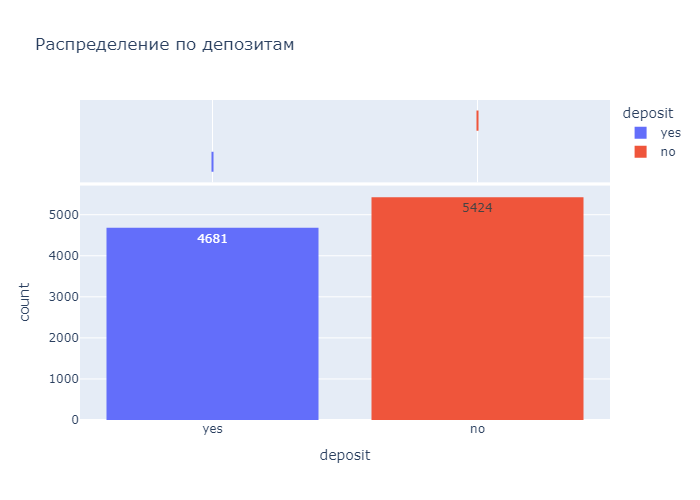

In [15]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
fig = px.histogram(
    df, 
    x='deposit', 
    title='Распределение по депозитам',  # Улучшенный заголовок
    text_auto=True,  # Автоматическое добавление текста на столбцах
    color='deposit',  # Цветовая кодировка по признаку
    marginal='box',  # Добавление диаграммы размаха (box plot) для дополнительной информации
    nbins=20  # Увеличение количества бинов для более детального распределения
)
# Показ графика
fig.show('png')

**Соотношение классов(yes),(no) в(deposit) наших данных сбалансированны.**

### Задания 2

In [16]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%        2.000000      1.000000  
max      854.000000     58.000000

1. **AGE(возраст)**

Text(0, 0.5, 'Тип пользователя')

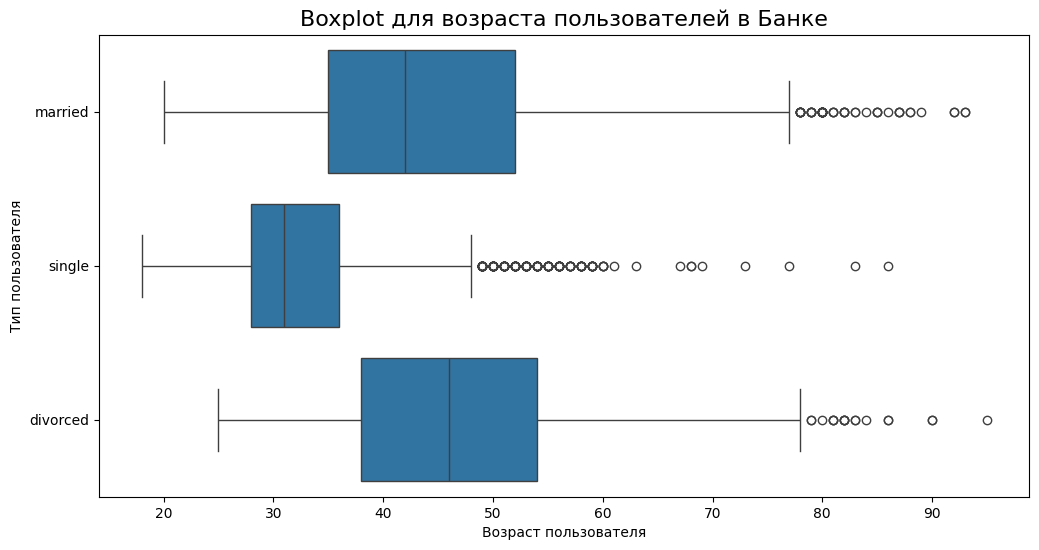

In [17]:
fig = plt.figure(figsize=(12, 6))
boxplot = sns.boxplot(data=df, x='age', y='marital')
boxplot.set_title('Boxplot для возраста пользователей в Банке', fontsize=16)
boxplot.set_xlabel('Возраст пользователя')
boxplot.set_ylabel('Тип пользователя')

> В сравнение по возрасту пользователей банка женатых(married), разведенных(divorced) и одиноких(single) показывает что (single) от 28-38 имеют возраст, (married) и (divorced) имеют почти одинаковый 38-55 возраст. И все категории имеют выброс в 90 лет.

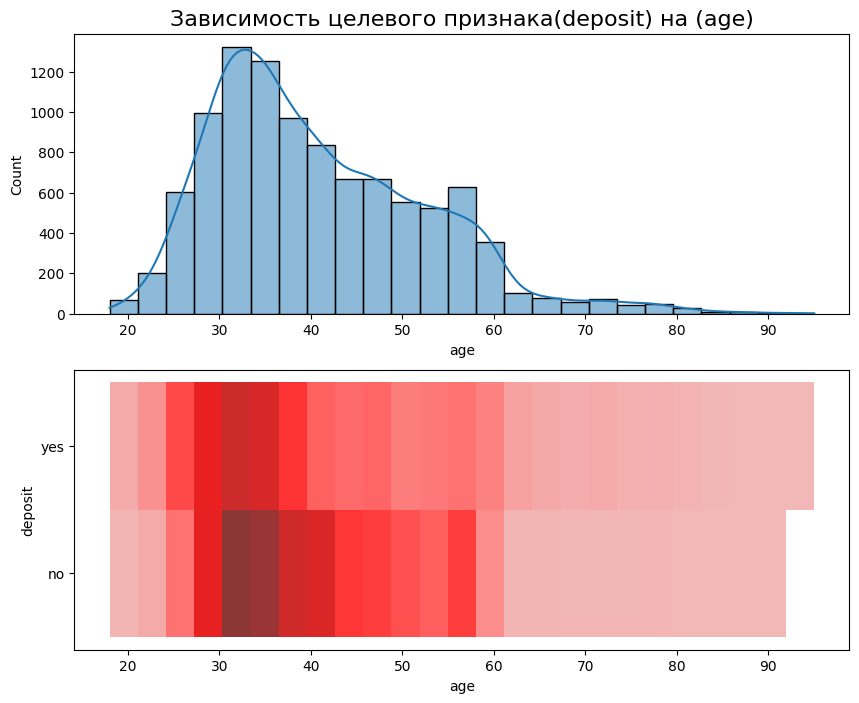

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=df,
    x='age',
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title('Зависимость целевого признака(deposit) на (age)', fontsize=16)
sns.histplot(
    data=df,
    x='age',
    y='deposit',
    bins=25,
    color='red',
    ax=axes[1]
);

> Исходя из двух данных в таблицах где целевого признака(deposit) мы рассматривали женатых(married), разведенных(divorced), одиноких(single) имея возрастную категорию (single) от 28-38, (married) и (divorced) 38-55, и таблицу с депозитом на возраст(age) мы можем сделать вывод что (single) имею депозит(deposit), а женатые(married), разведенные(divorced) почти нет депозитов(deposit).

2. **DAY(день, в который был последний контакт)**

In [19]:
# проведём замену значений целевого признака deposit на булевые: 1 - 'yes', 0 - 'no'
df['deposit'] = df['deposit'].apply(lambda x:int(1) if x == 'yes' else int(0))

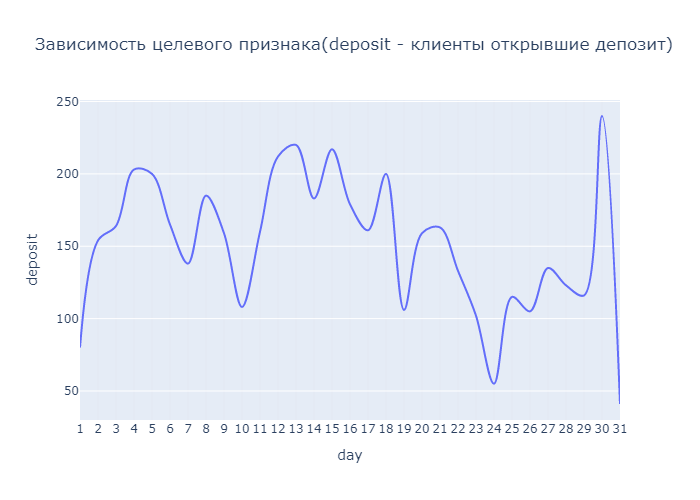

In [20]:
fig = px.line(pd.DataFrame(df.groupby('day')['deposit'].sum()).reset_index(), 
              x='day', 
              y='deposit',
              title='Зависимость целевого признака(deposit - клиенты открывшие депозит)',
              line_shape='spline'  # Использование сглаженной линии для более плавного вида
              )
fig.update_xaxes(
    showgrid=True, gridwidth=0.1, gridcolor='LightGray', 
    tickmode='linear'  # Линейный шаг между значениями оси X для улучшения читабельности
)
fig.show('png')

> Видим локальных клиентов к (deposit) в конце месяца(30 день), в середине месяца(с 12-18 дни), в начале месяца(4-5 дни), а также минимумы: первое и последнее дни месяца, 10 день месяца, 19 и 24 дни. Возможно это связано с получением дохода клиентами.

### Задания 4

In [21]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')
#постройте визуализации, иллюстрирующие результаты

job  marital  education default housing   loan   contact  \
count        10105    10105      10105   10105   10105  10105     10105   
unique          11        3          3       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2315     5715       5517    9939    5243   8712      7283   

        month poutcome  
count   10105    10105  
unique     12        4  
top       may  unknown  
freq     2617     7570

**JOB(сфера занятости)**

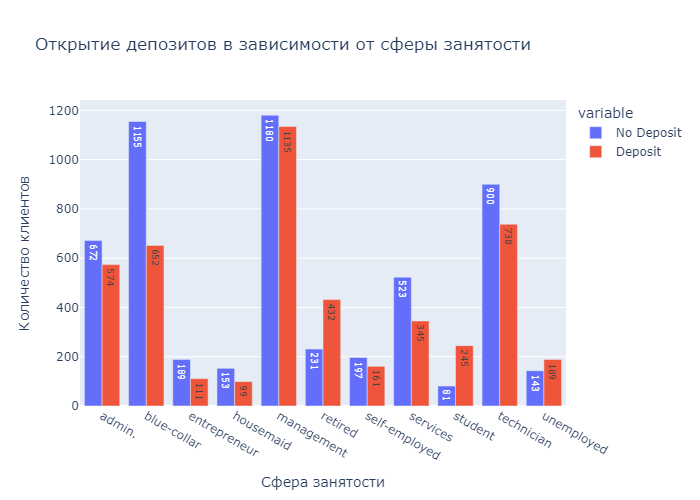

In [22]:
# Построение сводной таблицы
pivot_df = df.pivot_table(
    values='day',
    index='job',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index()

# Переименование колонок для удобства
pivot_df.columns = ['job', 'No Deposit', 'Deposit']

# Построение столбчатой диаграммы
fig = px.bar(
    pivot_df, 
    x='job', 
    y=['No Deposit', 'Deposit'],  # Имена категорий для оси y
    orientation='v',  # Вертикальная ориентация
    text_auto=True,  # Автоматическое добавление значений на столбцы
    barmode='group',  # Группировка столбцов
    title='Открытие депозитов в зависимости от сферы занятости',
    labels={'value': 'Количество клиентов', 'job': 'Сфера занятости'}
)
# Показ графика
fig.show('png')


Имеется тенденция к согласию открыть депозит у клиентов, находящихся на пенсии(retired), среди студентов(student), безработных(unemployed). Больше всего отказываются: клиенты, в рабочих специальностях(blue-collar), предприниматели(entrepreneur), занятые в сфере обслуживания(housemaid).

**EDUCATION(уровень образования)**

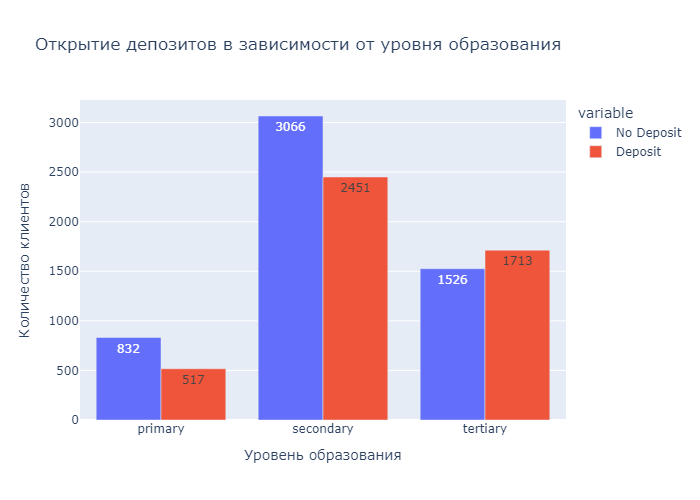

In [23]:
# Построение сводной таблицы
pivot_df = df.pivot_table(
    values='day',
    index='education',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index()

# Переименование колонок для удобства
pivot_df.columns = ['education', 'No Deposit', 'Deposit']

# Построение столбчатой диаграммы
fig = px.bar(
    pivot_df, 
    x='education', 
    y=['No Deposit', 'Deposit'],  # Имена категорий для оси y
    orientation='v',  # Вертикальная ориентация
    text_auto=True,  # Автоматическое добавление значений на столбцы
    barmode='group',  # Группировка столбцов
    title='Открытие депозитов в зависимости от уровня образования',
    labels={'value': 'Количество клиентов', 'education': 'Уровень образования'}
)
# Показ графика
fig.show('png')


Прослеживается положительная тенденция открытия депозита клиентов с уровнем образования tertiary.

**HOUSING(имеется ли кредит на жильё)**

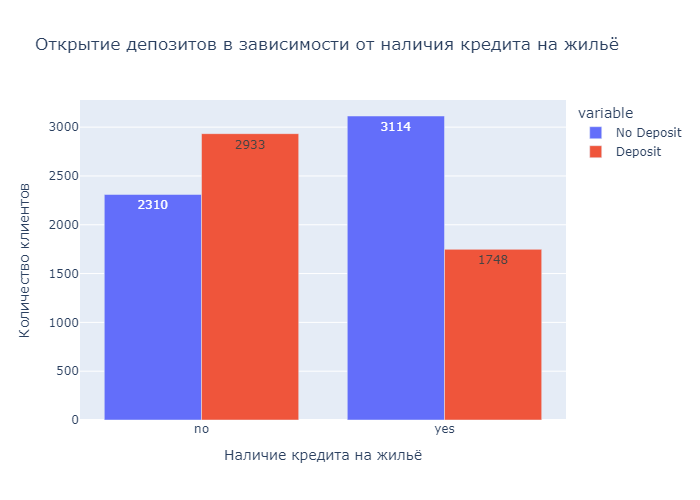

In [24]:
# Построение сводной таблицы
pivot_df = df.pivot_table(
    values='day',
    index='housing',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index()

# Переименование колонок для удобства
pivot_df.columns = ['housing', 'No Deposit', 'Deposit']

# Построение столбчатой диаграммы
fig = px.bar(
    pivot_df, 
    x='housing', 
    y=['No Deposit', 'Deposit'],  # Имена категорий для оси y
    orientation='v',  # Вертикальная ориентация
    text_auto=True,  # Автоматическое добавление значений на столбцы
    barmode='group',  # Группировка столбцов
    title='Открытие депозитов в зависимости от наличия кредита на жильё',
    labels={'value': 'Количество клиентов', 'housing': 'Наличие кредита на жильё'}
)
# Показ графика
fig.show('png')


Видна тенденция, что клиенты не обременённые кредитом на жильё в большинстве случаев соглашаются на открытие депозитов, чем те, у которых имеется кредит, что говорит о наличии у них свободных средств.

**MONTH(месяц, в котором был последний контакт)**

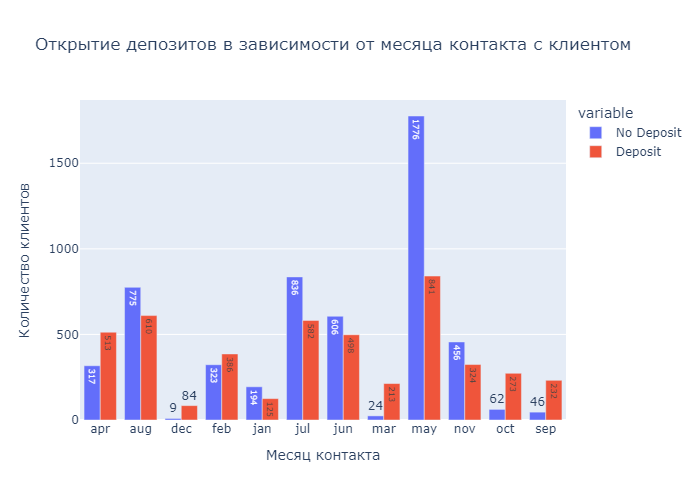

In [25]:
# Создаем сводную таблицу и сортируем месяцы в хронологическом порядке
pivot_df = df.pivot_table(
    values='day',
    index='month',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=True).reset_index()

# Переименование колонок для удобства
pivot_df.columns = ['month', 'No Deposit', 'Deposit']

# Построение столбчатой диаграммы
fig = px.bar(
    pivot_df, 
    x='month', 
    y=['No Deposit', 'Deposit'],  # Имена категорий для оси y
    orientation='v',  # Вертикальная ориентация
    text_auto=True,  # Автоматическое добавление значений на столбцы
    barmode='group',  # Группировка столбцов
    title='Открытие депозитов в зависимости от месяца контакта с клиентом',
    labels={'value': 'Количество клиентов', 'month': 'Месяц контакта'}
)

# Показ графика
fig.show('png')


Больше всего контактов было совершено в май месяце, положительная тенденция в открытии депозитов была отмечена в апрель, август за тем спад в феврале и рост июль, май.

**POUTCOME(результат прошлой маркетинговой кампании)**

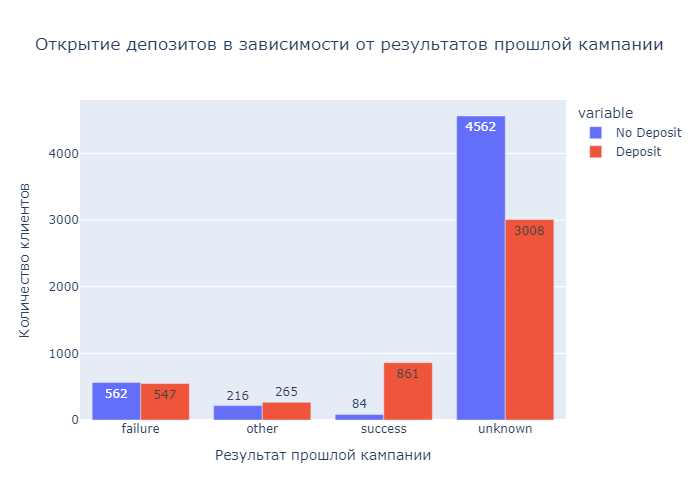

In [26]:
# Построение сводной таблицы
pivot_df = df.pivot_table(
    values='day',
    index='poutcome',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index()

# Переименование колонок для удобства
pivot_df.columns = ['poutcome', 'No Deposit', 'Deposit']

# Построение столбчатой диаграммы
fig = px.bar(
    pivot_df, 
    x='poutcome', 
    y=['No Deposit', 'Deposit'],  # Имена категорий для оси y
    orientation='v',  # Вертикальная ориентация
    text_auto=True,  # Автоматическое добавление значений на столбцы
    barmode='group',  # Группировка столбцов
    title='Открытие депозитов в зависимости от результатов прошлой кампании',
    labels={'value': 'Количество клиентов', 'poutcome': 'Результат прошлой кампании'}
)

# Показ графика
fig.show('png')


Клиенты, согласившиеся открыть депозит по результатам прошлой кампании(success) охотно открывают депозит и в результате новой маркетинговой кампании остались лояльными.

### Задания 6

In [27]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   0           562
          1           547
other     1           265
          0           216
success   1           861
          0            84
unknown   0          4562
          1          3008
Name: count, dtype: int64

Для клиентов группы poutcome(succes) в предыдущей маркетинговой кампании депозитов больше и за счет прошлой маркетинговой кампании в текущей тоже наблюдается увелечения депозитов.

### Задание 7

In [28]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
percent_failure = round((df.groupby('month')['deposit'].count() - df.groupby('month')['deposit'].sum()) 
                        / df.groupby('month')['deposit'].count() * 100).sort_values(ascending=False)
print(f'В {percent_failure.index[0]} месяце больше всего отказывались от открытия депозита.')

В may месяце больше всего отказывались от открытия депозита.


### Задание 8

In [29]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def create_age_group(age):
    """ Разбивает клиентов на возрастные группы

    Args:
        age (int): возраст

    Returns:
        age_group(object): возрастная группа
    """
    if age < 30:
        age_group = '<30'
    elif 30 <= age < 40:
        age_group = '30-40'
    elif 40 <= age < 50:
        age_group = '40-50'
    elif 50 <= age < 60:
        age_group = '50-60'
    else:
        age_group = '60+'
    return age_group

df['age_group'] = df['age'].apply(create_age_group)

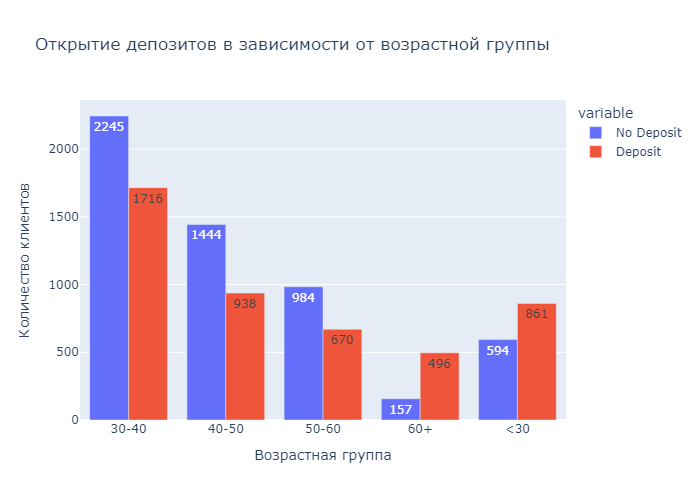

In [30]:
# Построение сводной таблицы
pivot_df = df.pivot_table(
    values='day',
    index='age_group',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index()

# Переименование колонок для удобства
pivot_df.columns = ['age_group', 'No Deposit', 'Deposit']

# Построение столбчатой диаграммы
fig = px.bar(
    pivot_df, 
    x='age_group', 
    y=['No Deposit', 'Deposit'],  # Имена категорий для оси y
    orientation='v',  # Вертикальная ориентация
    text_auto=True,  # Автоматическое добавление значений на столбцы
    barmode='group',  # Группировка столбцов
    title='Открытие депозитов в зависимости от возрастной группы',
    labels={'value': 'Количество клиентов', 'age_group': 'Возрастная группа'}
)
# Показ графика
fig.show('png')


Две возрастные группы, которые склонны открывать депозит - <30 и 60+.

### Задания 9 и 10

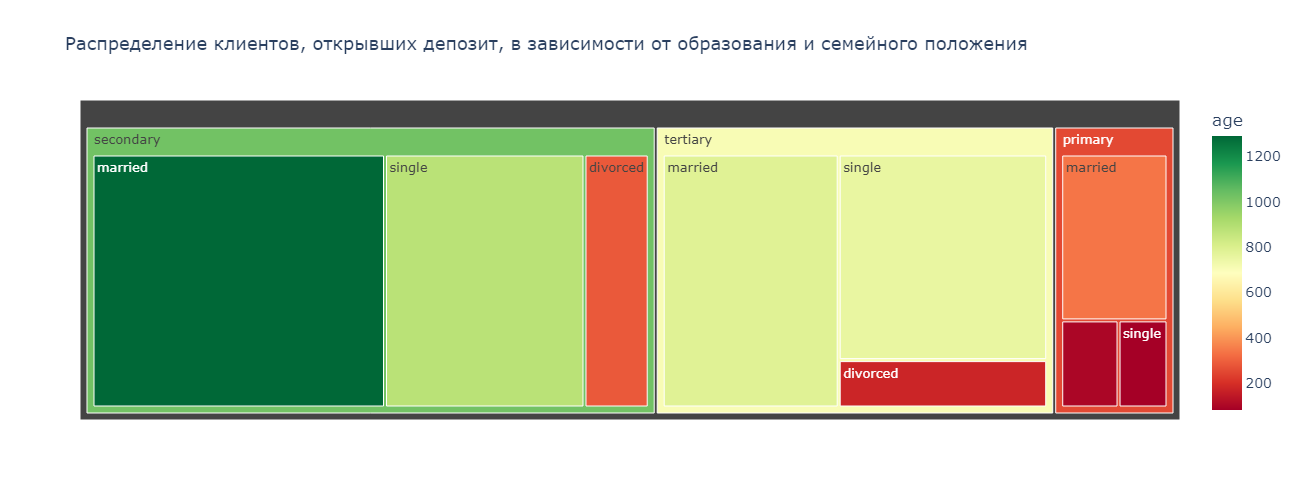

In [31]:
#(если рассматривать тех, кто открыл депозит)
p1 = df[df['deposit'] == 1]
p1 = pd.DataFrame(p1.pivot_table(
    values='age',  # Считаем количество людей
    index=['education', 'marital'],  # Иерархия: образование и семейное положение
    aggfunc='count',
    fill_value=0
)).reset_index()

# Построение тримапа
fig = px.treemap(
    data_frame=p1,  # DataFrame
    path=['education', 'marital'],  # Категории для иерархии
    values='age',  # Количество людей, как размер блоков
    color='age',  # Цветовая палитра по количеству людей
    color_continuous_scale='RdYlGn',  # Цветовая шкала от красного к зеленому
    hover_data={'age': True},  # Показать количество людей при наведении
    height=500,  # Высота
    width=1300,  # Ширина
    title='Распределение клиентов, открывших депозит, в зависимости от образования и семейного положения'  # Заголовок
)

# Настройка макета
fig.update_layout(
    title_font_size=18,  # Увеличенный размер шрифта для заголовка
    font=dict(size=14),  # Увеличенный шрифт для текста
    uniformtext_minsize=12,  # Минимальный размер текста в блоках
    uniformtext_mode='hide'  # Скрывать текст, если он не помещается
)

# Отображаем график
fig.show('png')

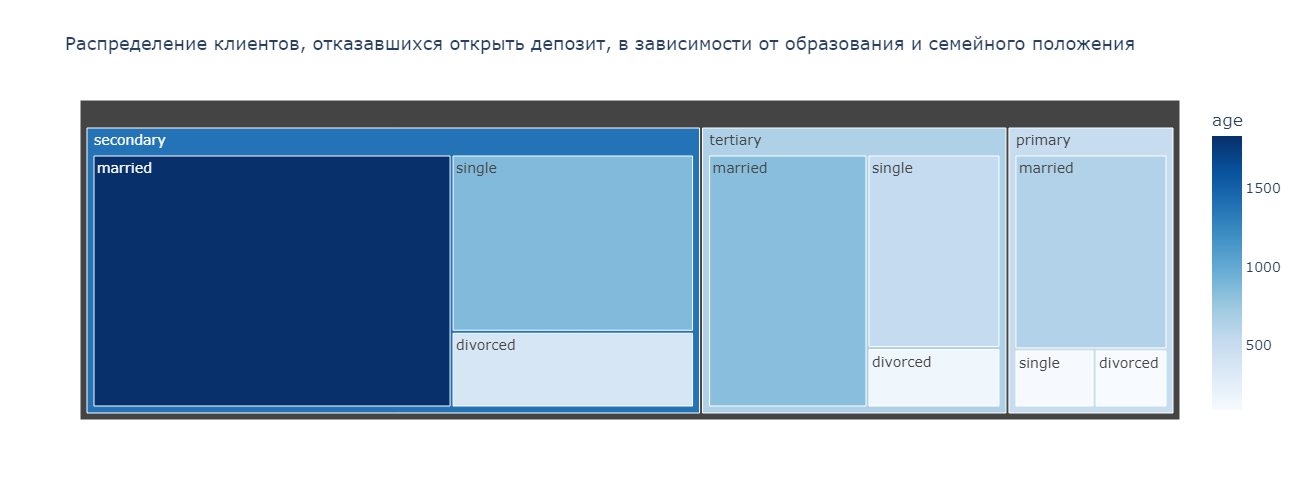

In [32]:
# Формируем таблицу для тех, кто отказался открыть депозит
p2 = df[df['deposit'] == 0]
p2 = pd.DataFrame(p2.pivot_table(
    values='age',  # Количество людей
    index=['education', 'marital'],  # Иерархия: образование и семейное положение
    aggfunc='count',
    fill_value=0
)).reset_index()

# Построение тримапа
fig = px.treemap(
    data_frame=p2,  # DataFrame
    path=['education', 'marital'],  # Категории для иерархии
    values='age',  # Количество людей, как размер блоков
    color='age',  # Цветовая палитра по количеству людей
    color_continuous_scale='Blues',  # Спокойная синяя палитра для отказов
    hover_data={'age': True},  # Показать количество людей при наведении
    height=500,  # Высота
    width=1300,  # Ширина
    title='Распределение клиентов, отказавшихся открыть депозит, в зависимости от образования и семейного положения'  # Заголовок
)

# Настройка макета
fig.update_layout(
    title_font_size=18,  # Увеличенный размер шрифта для заголовка
    font=dict(size=14),  # Увеличенный шрифт для текста
    uniformtext_minsize=12,  # Минимальный размер текста в блоках
    uniformtext_mode='hide'  # Скрывать текст, если он не помещается
)

# Отображаем график
fig.show('png')


Пересечение в двух категориях является самым многочисленным для клиентов и согласившиеся взять депозит и отказавшихся: с семейные положением married и образованием secondary.

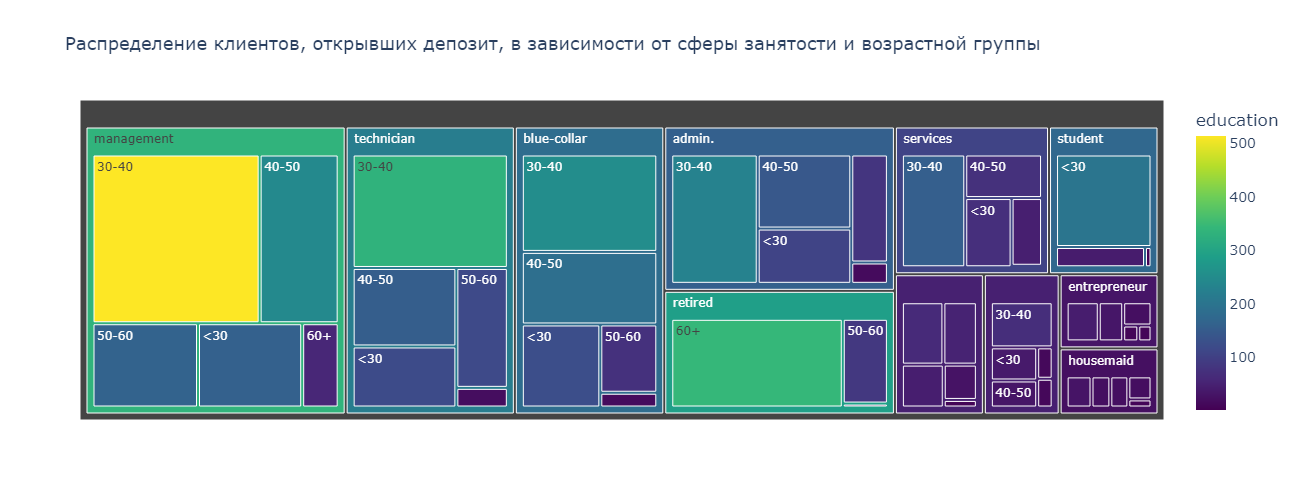

In [33]:
# Формируем таблицу для тех, кто открыл депозит
p3 = df[df['deposit'] == 1]
p3 = pd.DataFrame(p3.pivot_table(
    values='education',  # Количество людей
    index=['job', 'age_group'],  # Иерархия: сфера занятости и возрастная группа
    aggfunc='count',
    fill_value=0
)).reset_index()

# Построение тримапа
fig = px.treemap(
    data_frame=p3,  # DataFrame
    path=['job', 'age_group'],  # Категории для иерархии
    values='education',  # Количество клиентов, как размер блоков
    color='education',  # Цветовая палитра по количеству клиентов
    color_continuous_scale='Viridis',  # Цветовая шкала от желтого к фиолетовому
    hover_data={'education': True},  # Показать количество людей при наведении
    height=500,  # Высота
    width=1300,  # Ширина
    title='Распределение клиентов, открывших депозит, в зависимости от сферы занятости и возрастной группы'  # Заголовок
)

# Настройка макета
fig.update_layout(
    title_font_size=18,  # Увеличенный размер шрифта для заголовка
    font=dict(size=14),  # Увеличенный шрифт для текста
    uniformtext_minsize=12,  # Минимальный размер текста в блоках
    uniformtext_mode='hide'  # Скрывать текст, если он не помещается
)

# Отображаем график
fig.show('png')

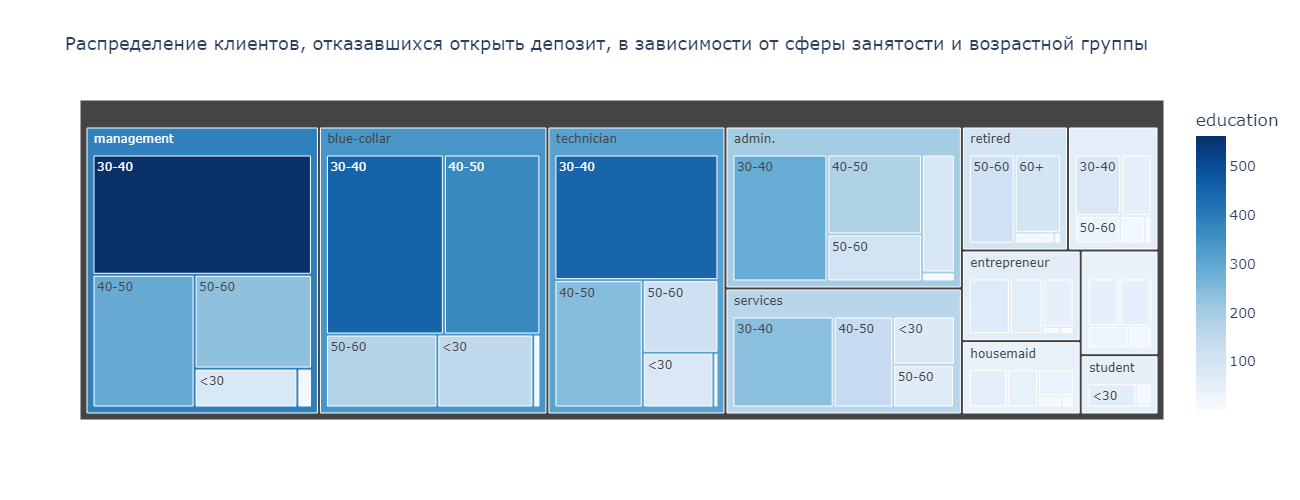

In [34]:
# Формируем таблицу для тех, кто отказался открыть депозит
p4 = df[df['deposit'] == 0]
p4 = pd.DataFrame(p4.pivot_table(
    values='education',  # Количество людей
    index=['job', 'age_group'],  # Иерархия: сфера занятости и возрастная группа
    aggfunc='count',
    fill_value=0
)).reset_index()

# Построение тримапа
fig = px.treemap(
    data_frame=p4,  # DataFrame
    path=['job', 'age_group'],  # Категории для иерархии
    values='education',  # Количество клиентов, как размер блоков
    color='education',  # Цветовая палитра по количеству клиентов
    color_continuous_scale='Blues',  # Цветовая шкала для отказов
    hover_data={'education': True},  # Показать количество людей при наведении
    height=500,  # Высота
    width=1300,  # Ширина
    title='Распределение клиентов, отказавшихся открыть депозит, в зависимости от сферы занятости и возрастной группы'  
)

# Настройка макета
fig.update_layout(
    title_font_size=18,  # Увеличенный размер шрифта для заголовка
    font=dict(size=14),  # Увеличенный шрифт для текста
    uniformtext_minsize=12,  # Минимальный размер текста в блоках
    uniformtext_mode='hide'  # Скрывать текст, если он не помещается
)

# Отображаем график
fig.show('png')


В обеих группах самая многочисленная категория занятых в сфере managment в возрастной группе 30-40.

### Задание 11

In [35]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
round(df.pivot_table(
    values='day',
    index=['education', 'marital'],    
    columns='deposit',
    aggfunc='count',
    fill_value=0)[1]/df.groupby(['education', 'marital'])['deposit'].count() * 100)

education  marital 
primary    divorced    51.0
           married     35.0
           single      45.0
secondary  divorced    43.0
           married     41.0
           single      50.0
tertiary   divorced    52.0
           married     49.0
           single      59.0
dtype: float64

Клиенты, которые чаще открывают депозит имеют уровень образования (tertiary) и семейный статус (single) или (divorced), а также с образованием (primary) и семейным статусом (divorced).

## Часть 3: Отбор и преобразование данных

### Задание 1

In [36]:
# преобразуйте уровни образования
label_encoder = LabelEncoder() # кодируем порядковым кодировщиком
data_educ = label_encoder.fit_transform(df['education'])
df['education_cod'] = data_educ

# преобразуйте возрастные группы
data_age = label_encoder.fit_transform(df['age_group'])
df['age_group'] = data_age

In [37]:
#Найдите сумму получившихся значений для признака education
print(df['education_cod'].sum())

11995


### Задания 2

In [38]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['housing_bin'] = df['housing'].apply(lambda x: int(1) if x == 'yes' else int(0))
df['default_bin'] = df['default'].apply(lambda x: int(1) if x == 'yes' else int(0))
df['loan_bin'] = df['loan'].apply(lambda x: int(1) if x == 'yes' else int(0))

### Задания 3

In [39]:
#Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit.
print(round(df['deposit'].std(), 3))

0.499


In [40]:
df_b = df.copy()
df_b.shape

(10105, 22)

### Задание 4

In [41]:
# создайте дамми-переменные
df_b = pd.get_dummies(df_b, columns=['job', 'marital', 'contact', 'month', 'poutcome'],
                      prefix=['job', 'marital', 'contact', 'month', 'poutcome'])
df_b = df_b.drop(columns=['age', 'education', 'default', 'loan', 'housing'])

In [42]:
df_b.shape

(10105, 45)

### Задания 5

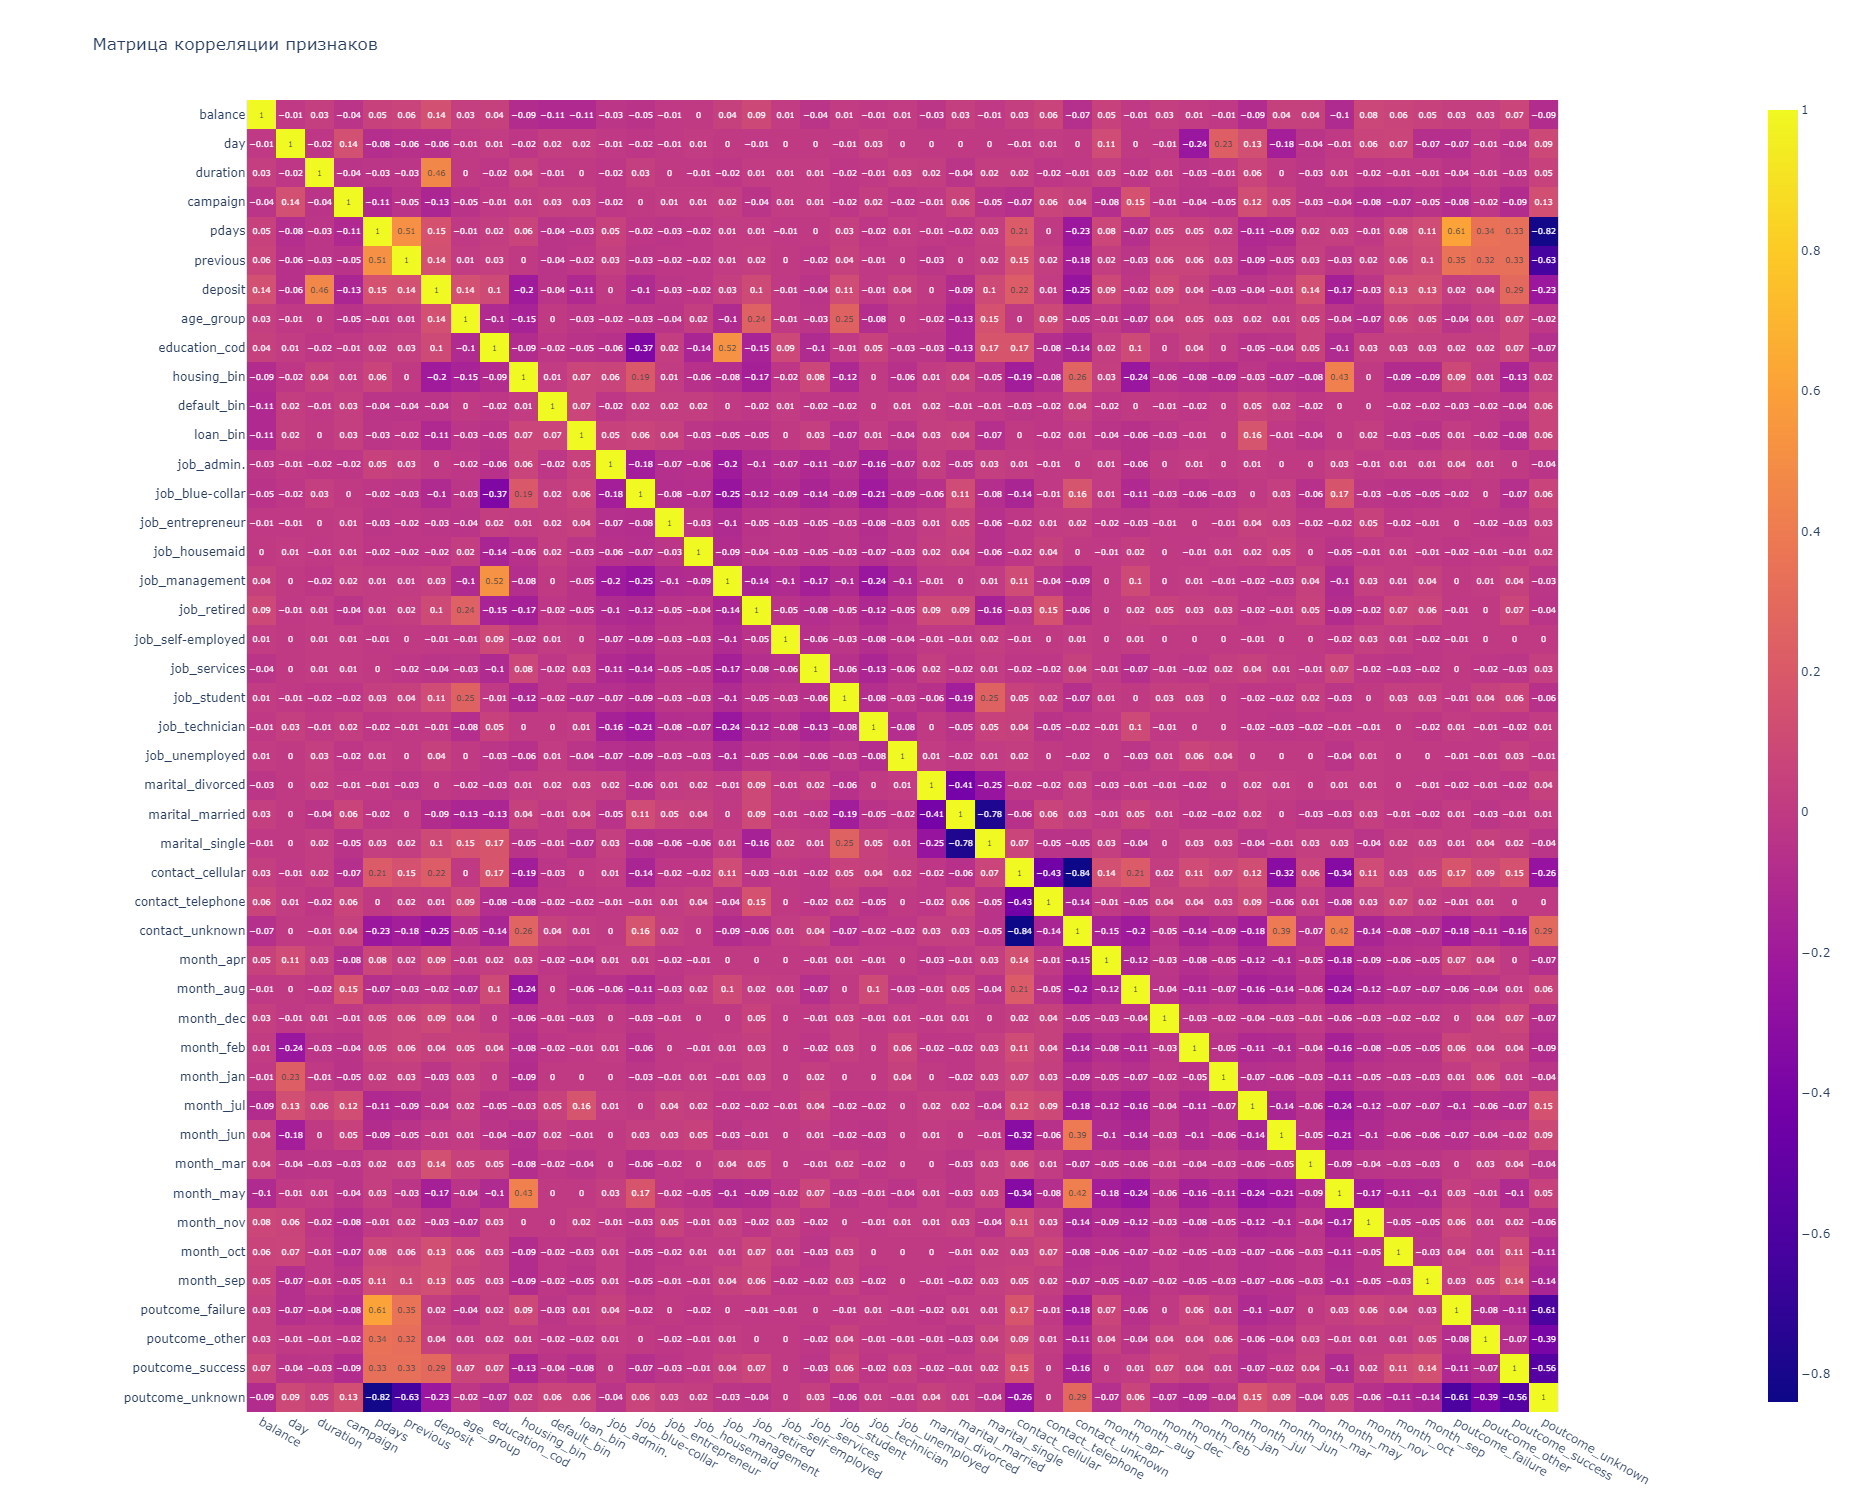

In [43]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corrs = round(df_b.corr(), 2)
fig = px.imshow(
    img=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    text_auto=True,    
    title='Матрица корреляции признаков',
    width=1850,
    height=1500
    )
fig.show('png')

### Задания 6

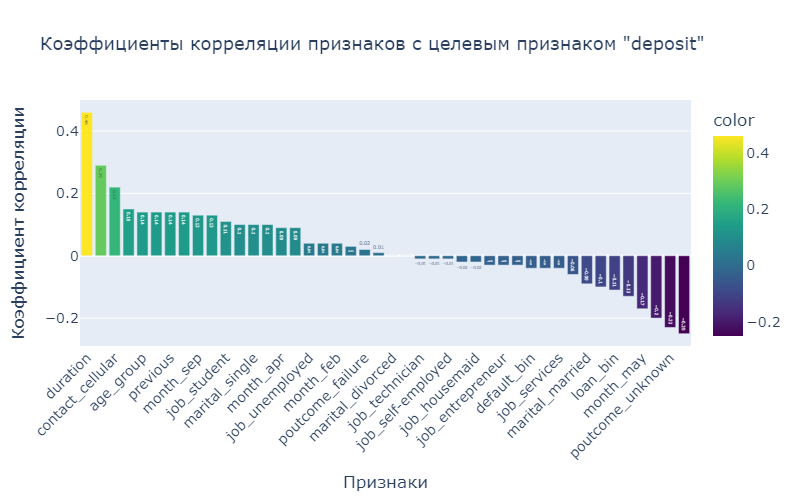

In [44]:
# Расчет коэффициентов корреляции
corrs = round(df_b.corr(), 2).drop('deposit', axis=0)

# Построение графика
fig = px.bar(
    corrs['deposit'].sort_values(ascending=False),  # Отсортированные коэффициенты корреляции
    x=corrs['deposit'].sort_values(ascending=False).index,  # Названия признаков
    y='deposit',  # Значения коэффициентов корреляции
    text_auto=True,  # Показывать значения на графике
    color=corrs['deposit'].sort_values(ascending=False),  # Цветовая палитра по значениям
    color_continuous_scale='Viridis',  # Цветовая шкала
    title='Коэффициенты корреляции признаков с целевым признаком "deposit"',  # Обновленный заголовок
    labels={'deposit': 'Коэффициент корреляции'},  # Подписи осей
    height=500,  # Высота графика
    width=800  # Ширина графика
)

# Настройка макета
fig.update_layout(
    title_font_size=18,  # Размер шрифта заголовка
    xaxis_title='Признаки',  # Подпись оси X
    yaxis_title='Коэффициент корреляции',  # Подпись оси Y
    font=dict(size=14),  # Размер шрифта текста
    xaxis_tickangle=-45  # Поворот подписей оси X для лучшей читаемости
)

# Отображение графика
fig.show('png')


Мультиколлинеарность признаков отсутсвует.

### Задания 7

In [55]:
# разделим датафрейм на целевой и предикты
X = df_b.drop(['deposit'], axis=1)
y = df_b['deposit']
# разделим датафрейм на тестовые и тренировочные
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print(f'Размер тренировочных выборки X_train={X_train.shape}, y_train={y_train.shape[0]}')
print(f'Размер тестовой выборки X_test={X_test.shape}, y_test={y_test.shape[0]}')

Размер тренировочных выборки X_train=(6770, 44), y_train=6770
Размер тестовой выборки X_test=(3335, 44), y_test=3335


### Задание 9

In [46]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()
selector_col = list(selector.get_feature_names_out())
selector_col

['balance',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'housing_bin',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [47]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)                           # fit() только на train данных
X_train_scal = scaler.transform(X_train)    # fransform() на train данных
X_test_scal = scaler.transform(X_test)      # fransform() на test данных

print(X_test_scal[:, 0].mean().round(2))  # для признака balance, обратите внимание именно на столбец

0.47


In [49]:
# нормализуйте данные с помощью minmaxsxaler
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
X_train_scal = scaler.fit_transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)
X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, columns=X_test.columns)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [56]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_model = linear_model.LogisticRegression(
    random_state=42,
    solver='sag',
    max_iter=1000)

log_model.fit(X_train_scal, y_train)
y_test_pred = log_model.predict(X_test_scal)
y_train_pred = log_model.predict(X_train_scal)
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      3634
           1       0.85      0.80      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      1790
           1       0.82      0.77      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.81      0.81      3335
weighted avg       0.82      0.82      0.82      3335



### Задания 2 - 3

In [57]:
# обучите решающие деревья, настройте максимальную глубину
tree_model = tree.DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=6)
tree_model.fit(X_train_scal, y_train)
y_test_pred = tree_model.predict(X_test_scal)
y_train_pred = tree_model.predict(X_train_scal)
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      3634
           1       0.78      0.86      0.82      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.80      3335
weighted avg       0.81      0.81      0.81      3335



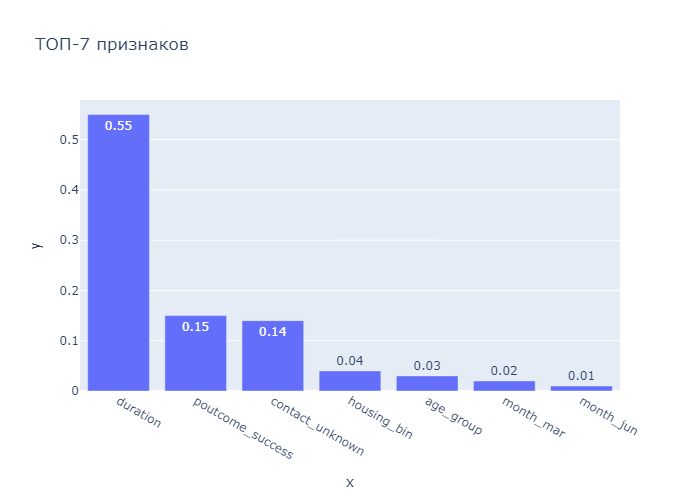

In [52]:
# визуализируем важные признаки в дереве решений
gr_1 = pd.DataFrame([tree_model.feature_importances_], columns=X_train_scal.columns)
fig = px.bar(x = list(gr_1.loc[0].sort_values(ascending=False)[0:7].index),
    y=round(gr_1.loc[0].sort_values(ascending=False)[0:7], 2),
    text_auto=True,
    title='ТОП-7 признаков'    
)
fig.show('png')

### Задания 4

In [53]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(150, 100))
#Строим граф дерева решений
tree.plot_tree(
    tree_model, #объект обученного дерева
    feature_names=X_train_scal.columns, #наименования факторов
    class_names=["0 - Not deposit", "1 - Yes deposit"], #имена классов
    filled=True, #расцветка графа
    fontsize=60    
    );

### Задания 5

In [58]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
# задаём сетку параметров
param_grid = [
              {'min_samples_split': [2, 5, 7, 10] , # Минимальное количество выборок, необходимое для разделения внутреннего узла
              'max_depth':[3,5,7] # Максимальная глубина дерева
               }              
]

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy',
        
        random_state=42, #генератор случайных чисел
        ), 
    param_grid=param_grid, 
    n_jobs = -1,
    scoring='f1'
)  

grid_search.fit(X_train_scal, y_train) 
print(f'Best Hyperparameter Values: {grid_search.best_params_}')
print(f'Best Models:{grid_search.best_estimator_}')
print(f'Best score Cross validation: {grid_search.best_score_:.3f}')
y_test_pred = grid_search.predict(X_test_scal)
y_train_pred = grid_search.predict(X_train_scal)
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')

Best Hyperparameter Values: {'max_depth': 7, 'min_samples_split': 10}
Best Models:DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10,
                       random_state=42)
Best score Cross validation: 0.795
Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      3634
           1       0.85      0.77      0.81      3136

    accuracy                           0.83      6770
   macro avg       0.83      0.83      0.83      6770
weighted avg       0.83      0.83      0.83      6770

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.81      0.75      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [59]:
# обучите на ваших данных случайный лес
forest_model = ensemble.RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_leaf=5,
    criterion='gini'
)
forest_model.fit(X_train_scal, y_train)
y_train_pred = forest_model.predict(X_train_scal)
y_test_pred = forest_model.predict(X_test_scal)
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      3634
           1       0.85      0.89      0.87      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.88      0.87      6770
weighted avg       0.88      0.87      0.87      6770

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1790
           1       0.81      0.86      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335



### Задания 2 и 3

In [60]:
# используйте для классификации ada-бустинг и сравните качество со случайным лесом
from sklearn.ensemble import AdaBoostClassifier
forest_model_b = ensemble.RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    max_depth=5,
    min_samples_leaf=5,
    criterion='gini',
    n_jobs = -1
)

ada = AdaBoostClassifier(
    estimator=forest_model_b,
    random_state=42,
    learning_rate=0.05,
    n_estimators=300      
)

%time ada.fit(X_train_scal, y_train)
y_train_pred = ada.predict(X_train_scal)
y_test_pred = ada.predict(X_test_scal)
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')

CPU times: total: 5min 53s
Wall time: 2min 50s
Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.91      0.88      0.90      3634
           1       0.87      0.90      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1790
           1       0.82      0.86      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335



In [61]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=300,
    random_state=42,
    min_samples_leaf=5,
    learning_rate=0.05,
    max_depth=5         
)

%time gb.fit(X_train_scal, y_train)
y_train_pred = gb.predict(X_train_scal)
y_test_pred = gb.predict(X_test_scal)
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')

CPU times: total: 4.92 s
Wall time: 5.1 s
Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.93      0.90      0.92      3634
           1       0.89      0.92      0.91      3136

    accuracy                           0.91      6770
   macro avg       0.91      0.91      0.91      6770
weighted avg       0.91      0.91      0.91      6770

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1790
           1       0.82      0.87      0.85      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335



### Задание 4

In [67]:
# объедините уже известные вам алгоритмы с помощью стекинга
from sklearn.ensemble import StackingClassifier
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
            ('dt', tree.DecisionTreeClassifier(
            criterion='entropy',
            min_samples_leaf=5,
            max_depth=6,
            random_state=42
            )
    ),
            ('log_reg', linear_model.LogisticRegression(
            solver='sag',
            random_state=42 
            )
    ),
            ('gb', ensemble.GradientBoostingClassifier(
            learning_rate=0.05,
            n_estimators=300,
            min_samples_leaf=5,
            max_depth=5,
            random_state=42
            )
    )
    
]
#Создаем объект класса стекинг
stack_model = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
 
%time stack_model.fit(X_train_scal, y_train)
y_train_pred = stack_model.predict(X_train_scal)
y_test_pred = stack_model.predict(X_test_scal)
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')

CPU times: total: 25.5 s
Wall time: 25.6 s
Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      3634
           1       0.89      0.91      0.90      3136

    accuracy                           0.91      6770
   macro avg       0.91      0.91      0.91      6770
weighted avg       0.91      0.91      0.91      6770

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.88      0.85      0.86      1790
           1       0.83      0.86      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335



### Задание 5

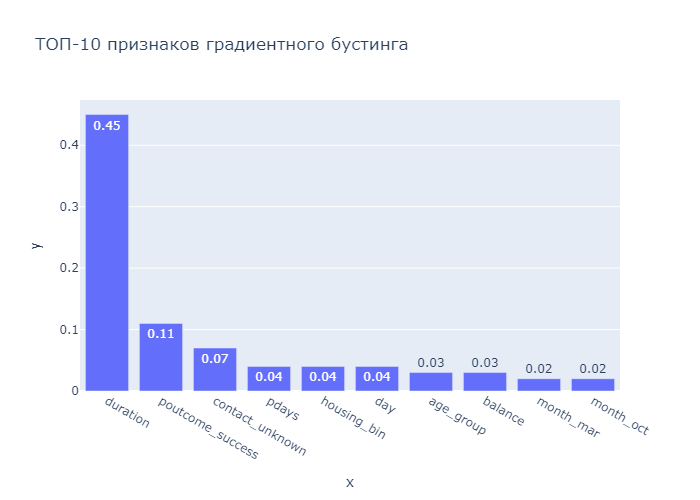

In [68]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
gr_2 = pd.DataFrame([gb.feature_importances_], columns=gb.feature_names_in_)
fig = px.bar(x = list(gr_2.loc[0].sort_values(ascending=False)[0:10].index),
    y=round(gr_2.loc[0].sort_values(ascending=False)[0:10], 2),
    text_auto=True,
    title='ТОП-10 признаков градиентного бустинга'    
)
fig.show('png')

### Задания 6

In [69]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
def optuna_rf(trial):
  """Функция, обучающая модель Random Forest
    по переданным гиперпараметрам

  Args:
      trial : класс, от которого вызываются гиперпараметры

  Returns:
      score(float): метрика F1
  """
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  
  # создаем модель
  model = forest_model
  
  # обучаем модель 
  model.fit(X_train_scal, y_train)
  y_train_pred = model.predict(X_train)
  score = metrics.f1_score(y_train, y_train_pred)

  return score

### Задания 7

In [70]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scal, y_train)
y_test_pred = model.predict(X_test_scal)

score = metrics.f1_score(y_test, y_test_pred)
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'F1 for test data={score:.2f}')
print(f'Accuracy for test data={metrics.accuracy_score(y_test, y_test_pred):.2f}')

[I 2024-09-17 09:03:22,099] A new study created in memory with name: RandomForestClassifier
[I 2024-09-17 09:03:22,624] Trial 0 finished with value: 0.6331516252776095 and parameters: {'n_estimators': 114, 'max_depth': 14, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6331516252776095.
[I 2024-09-17 09:03:23,117] Trial 1 finished with value: 0.6331516252776095 and parameters: {'n_estimators': 180, 'max_depth': 17, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6331516252776095.
[I 2024-09-17 09:03:23,607] Trial 2 finished with value: 0.6331516252776095 and parameters: {'n_estimators': 147, 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6331516252776095.
[I 2024-09-17 09:03:24,091] Trial 3 finished with value: 0.6331516252776095 and parameters: {'n_estimators': 101, 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6331516252776095.
[I 2024-09-17 09:03:24,591] Trial 4 finished with value: 0.6331516252776095 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 114, 'max_depth': 14, 'min_samples_leaf': 4}
F1 for test data=0.84
Accuracy for test data=0.85
CPU times: total: 25.8 s
Wall time: 25.9 s


### <center>  Выводы

Итоговый свод по моделям, оценённым по метрикам Accuracy и F1:
|       МЕТОД                  | Accuracy |    F1   |
|------------------------------|----------|---------|
| LogisticRegression           |   0.80   |   0.82  |
| DecisionTreeClassifier       |   0.80   |   0.81  |
| RandomForestClassifier       |   0.83   |   0.84  |
| AdaBoostClassifier           |   0.84   |   0.85  |
| GradientBoostingClassifier   |   0.85   |   0.85  |
| StackingClassifier           |   0.84   |   0.85  |
| RandomForestClassifier Optuna|   0.84   |   0.85  |

Для решения задачи классификации в данном кейсе хорошо себя показали модели бустинга(GradientBoostingClassifier) и стэкинга(StackingClassifier), а также модель(RandomForestClassifier) случайного леса с подобранными гиперпараметрами методом Optuna.

В ходе исследования выделили три наиболее важных признака(далее признаки перечислены по мере убывания важности):

1. duration (продолжительность контакта в секундах) - оптимальная продолжительность контакта находится в диапазоне - от 240 до 340 секунд;
2. poutcome_success(результат прошлой маркетинговой кампании - success(успех, согласие));
3. contact_unknown(тип контакта с клиентом- unknown(неизвестный)).

> Данные факторы показывают, что превалирующее значение в решении открыть клиентом депозит(со стороны клиента) играют внешние факторы, такие как упомянутые ранее, например, продолжительность контакта, тип контакта с клиентом т.е. то, что зависит от сотрудников банка, занятых в данной маркетинговой кампании - их навыков коммуникаций, проведение холодных звонков, умение лаконично и доступно излагать информацию клиентам и т.д.

Вторичны факторы внутренние для конкретного клиента:

- job_student, job_retired(сфера занятости) - целевая аудитория это студенты и клиенты находящиеся на пенсии;
- age_group(возрастная группа) - потенциальные группы - младше 31 и старше 60;
- marital (семейное положение) - клиенты не состоящие в браке;
- month(месяц контакта с клиентом) - наиболее благоприятный месяц для открытия депозита, когда стоит увеличить активность контактов с клиентами - это декабрь, наименее результативный - май.

Также стоит упомянуть о лояльности клиентах - как показали исследования клиентов ранее открывшие депозиты в прошлые маркетиновые кампании охотно соглашаются и в новой кампании - данную группу необходимо использовать в новых маркетинговых кампаниях и сохранять их лояльность. При планировании новой маркетинговой кампании необходимо обязательно более тщательно подходить к вопросу выбора контакта с клиентом - в данной кампании порядка 21% вид контакта неизвестен, данный факт касается также и poutcome(результат прошлой маркетинговой кампании).